# Explore tokenization coverage across vocabs

Please note that as of March 2024, the TileDB-SOMA database backend does not work on CCC login nodes. In order to run this notebook, you must use a compute node. GPU is not necessary so a simple compute node like `jbsub -mem 32g -cores 8 -q x86_1h -interactive bash` would work.

If you only want to see the data, you can run this notebook locally (tested on MacOS with brew python) by setting `uri=None`.

## Loading dataset and exploration

In [1]:
from functools import reduce
from itertools import combinations
from operator import itemgetter

import cellxgene_census as cc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from scanpy import read_h5ad

from bmfm_targets.tests import helpers
from bmfm_targets.tokenization import load_tokenizer

In [2]:
census = cc.open_soma()

experiment = census["census_data"]["homo_sapiens"]

The "stable" release is currently 2023-12-15. Specify 'census_version="2023-12-15"' in future calls to open_soma() to ensure data consistency.


In [3]:
census["census_info"]["summary"].read().concat().to_pandas()

,soma_joinid,label,value
0,0,census_schema_version,1.2.0
1,1,census_build_date,2023-10-23
2,2,dataset_schema_version,3.1.0
3,3,total_cell_count,68683222
4,4,unique_cell_count,40356133
5,5,number_donors_homo_sapiens,15588
6,6,number_donors_mus_musculus,1990


In [4]:
gene_data = experiment.ms["RNA"].var.read().concat().to_pandas()

In [5]:
gene_data

,soma_joinid,feature_id,feature_name,feature_length,nnz,n_measured_obs
0,0,ENSG00000233576,HTR3C2P,1057,69370,19581263
1,1,ENSG00000121410,A1BG,3999,5640476,62641311
2,2,ENSG00000268895,A1BG-AS1,3374,3071864,61946057
3,3,ENSG00000148584,A1CF,9603,734347,58195911
4,4,ENSG00000175899,A2M,6318,7894261,62704378
...,...,...,...,...,...,...
60659,60659,ENSG00000288719,RP4-669P10.21,4252,2826,1248980
60660,60660,ENSG00000288720,RP11-852E15.3,7007,99,1248980
60661,60661,ENSG00000288721,RP5-973N23.5,7765,0,0
60662,60662,ENSG00000288723,RP11-553N16.6,1015,18,1248980


In [6]:
vocab_coverage = gene_data.sort_values("nnz",ascending=False).nnz.cumsum() / gene_data.nnz.sum()

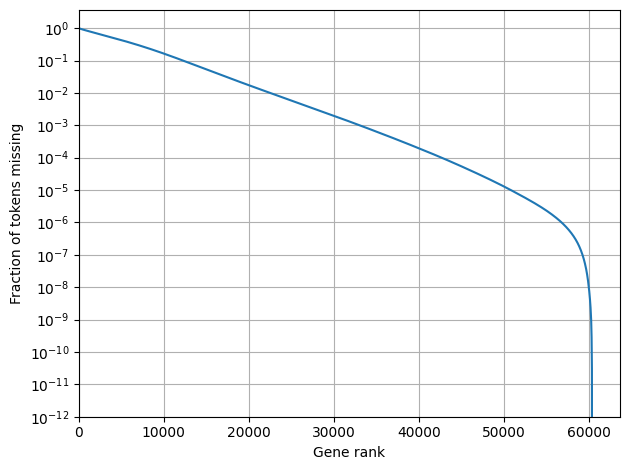

In [7]:
plt.plot(1 - vocab_coverage.values)
plt.yscale("log")
plt.grid("on")
plt.xlabel("Gene rank")
plt.ylabel("Fraction of tokens missing")
plt.tight_layout()
plt.yticks(np.logspace(0,-12,13))
_ = plt.xlim(xmin=0)

So we reach 99% coverage at ~22,000, 99.9% coverage at ~32,000, 99.99% coverage at ~42,000, 99.999% coverage at ~50,000 and 100% at 60,000.

## How much mileage do we get from the gene2vec tokenizer?

We have two tokenizers that we have been working with until now: `gene2vec` and `panglaodb_dynamic_tokenizer` aka everything in panglaodb train split. If we were to walk in to cellxgene with these guys, how much would we capture?

To start with, let's look at the gene2vec tokenizer:

In [8]:
gene2vec_vocab = load_tokenizer().vocab_get_field_specific_tokens("genes")
gene2vec_vocab = gene2vec_vocab[5:] # remove special tokens
old_not_new = set(gene2vec_vocab) - set(gene_data.feature_name)
new_not_old = set(gene_data.feature_name) - set(gene2vec_vocab)
shared = set(gene2vec_vocab) & set(gene_data.feature_name)

In [9]:
len(old_not_new), len(new_not_old), len(shared)

(4395, 40612, 20052)

So there are actually 4395 gene names that are present in the old vocab but not the new. That's kind of surprising. What if we were to use the old vocab as is with the cellxgene data, how much would we capture?

In [10]:
reads_captured_by_old = gene_data.set_index("feature_name").loc[list(shared)].nnz.sum()
reads_captured_by_old / gene_data.nnz.sum()

0.885722075919361

Not bad. We actually get 88.6% of the non-zero reads using the gene2vec vocab out of the box. That's somewhat reassuring. What's the best we could have done, if the 20052 were exactly the genes with the most coverage?

In [11]:
vocab_coverage.values[len(shared)]

0.9828972066856615

So 10% of the total reads are accounted for by genes that are in the top 20k but not in the 20k that are shared with gene2vec. That's significant enough to warrant our attention.

## Load previous symbol to current symbol mapping

What if the problem is actually the same genes that got renamed? Let's load the canonical mapping and check. Note this file is ~35MB so it may take a few seconds to dl and parse.

In [12]:
url = "https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/archive/monthly/json/hgnc_complete_set_2023-11-01.json"
url = "https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/json/hgnc_complete_set.json"
r = requests.get(url)
hgnc = r.json()
hgnc = hgnc["response"]

In [13]:
hgnc_df = pd.DataFrame(hgnc["docs"])

Some of the genes have previous names and symbols, some don't let's create a mapping of all the different previous symbols to the current ones. First will blow it up into a wide DataFrame (because prev_symbol is a list)

In [14]:
prev_df = hgnc_df[~hgnc_df.prev_symbol.isna()][["symbol", "prev_symbol"]].set_index("symbol").squeeze().apply(pd.Series)

In [15]:
prev_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
symbol,,,,,,,,,,,,,,,,,,
A1BG-AS1,NCRNA00181,A1BGAS,A1BG-AS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2ML1,CPAMD9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2MP1,A2MP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A3GALT2,A3GALT2P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A4GALT,P1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Then let's melt it back to a two column DataFrame:

In [16]:
prev_to_current_df = prev_df.reset_index().melt(id_vars='symbol',value_name="prev_symbol").dropna()[["prev_symbol", "symbol"]]

In [17]:
prev_to_current_df

,prev_symbol,symbol
0,NCRNA00181,A1BG-AS1
1,CPAMD9,A2ML1
2,A2MP,A2MP1
3,A3GALT2P,A3GALT2
4,P1,A4GALT
...,...,...
169198,OR4H4P,OR4H6P
181662,OR4H10,OR4H6P
194126,OR4H4,OR4H6P
206590,OR4H8P,OR4H6P


How many of these old_not_new genes would we catch in this way?

In [18]:
old_not_new_is_prev = {*prev_to_current_df.prev_symbol} & old_not_new
old_mapped_new = prev_to_current_df.set_index("prev_symbol").loc[[*old_not_new_is_prev]].symbol
len({*old_mapped_new} & {*gene_data.feature_name})

1156

And how much of the data does this account for?

In [19]:
enhanced_shared = ({*old_mapped_new} & {*gene_data.feature_name}) | shared
reads_captured_by_enhanced_old = gene_data.set_index("feature_name").loc[list(enhanced_shared)].nnz.sum()
reads_captured_by_enhanced_old / gene_data.nnz.sum()

0.9315377332605492

In [20]:
vocab_coverage.values[len(enhanced_shared)]

0.9866394789030727

Cool, once we do the mapping of the old missing genes we get 93% coverage, and only 5% of the reads are in the top 21k but not the shared 21k.

However, before we go off creating a mapping for everything, we need to consider the possibility that we are mapping from a good gene name to a bad gene name. Is that happening?

In [21]:
shared_prevs = shared & {*prev_to_current_df.prev_symbol}
shared_prevs_df = prev_to_current_df.set_index("prev_symbol").loc[[*shared_prevs]]
shared_prevs_df

,symbol
prev_symbol,
SLC9A3R1,NHERF1
HARS2,DTD1
FAM160B1,FHIP2A
FAM71D,GARIN2
METTL7B,TMT1B
...,...
C1orf112,FIRRM
FAM189A1,ENTREP2
SOGA1,MTCL2


Hmmm. That's 370 genes that exist in cellxgene AND in gene2vec with their prev_symbol name. Of these 370 that exist with their prev_symbol name, do we also have their new symbol??

In [22]:
len({*shared_prevs_df.reset_index().symbol} & {*gene_data.feature_name})

103

Great. So 103 genes are in the cellxgene in their previous version AND in their newly mapped name. We should probably leave these ones as they are. A lot of the time the mapping is not exactly 1:1. We should respect the original name if it is there.

We also have 265 genes which are present with their old names in gene2vec and in cellxgene but not with their new names:

In [23]:
len({*shared_prevs_df.reset_index().symbol} - {*gene_data.feature_name})

265

## Comparing by Ensembl gene id instead of symbol
Interestingly, we get slightly different results if we look by 

In [24]:
hgnc_vocab = {*map(itemgetter("symbol"), hgnc["docs"])}

In [25]:
hgnc_not_cellxgene = set(hgnc_vocab) - set(gene_data.feature_name)
cellxgene_not_hgnc = set(gene_data.feature_name) - set(hgnc_vocab)
shared = set(hgnc_vocab) & set(gene_data.feature_name)
len(hgnc_not_cellxgene), len(cellxgene_not_hgnc), len(shared)

(5120, 21942, 38722)

In [26]:
hgnc_ensg = {*map(itemgetter("ensembl_gene_id"), filter(lambda x: "ensembl_gene_id" in x, hgnc["docs"]))}
hgnc_not_cellxgene_ensg = set(hgnc_ensg) - set(gene_data.feature_id)
cellxgene_not_hgnc_ensg = set(gene_data.feature_id) - set(hgnc_ensg)
shared_ensg = set(hgnc_ensg) & set(gene_data.feature_id)
len(hgnc_not_cellxgene_ensg), len(cellxgene_not_hgnc_ensg), len(shared_ensg)

(103, 19562, 41102)

## Compile all our different vocabs

In [27]:
def get_vocab_from_dataset(dsroot=helpers.Zheng68kPaths.root):
    try:
        h5ad_path = next((dsroot / 'h5ad').glob("*"))
    except:
        print("no h5ad in dir ", dsroot)
        return {}
    ad = read_h5ad(h5ad_path)
    return {*ad.var_names}


In [28]:
paths = [getattr(helpers, i) for i in helpers.__dict__ if "Paths" in i]
roots = [*(getattr(x, next(filter(lambda y: "root" in y, x.__dict__))) for x in paths)]

In [29]:
vocabs = {p.name : get_vocab_from_dataset(p) for p in roots}
vocabs = {k:v for k, v in vocabs.items() if len(v) > 100}

no h5ad in dir  /u/dmichael/bmfm-targets/bmfm_targets/tests/resources/pretrain/panglao


In [30]:
# to get the nice plots to work
# !pip install upsetplot venny4py

In [31]:
import upsetplot

In [32]:
up = upsetplot.from_contents(vocabs)

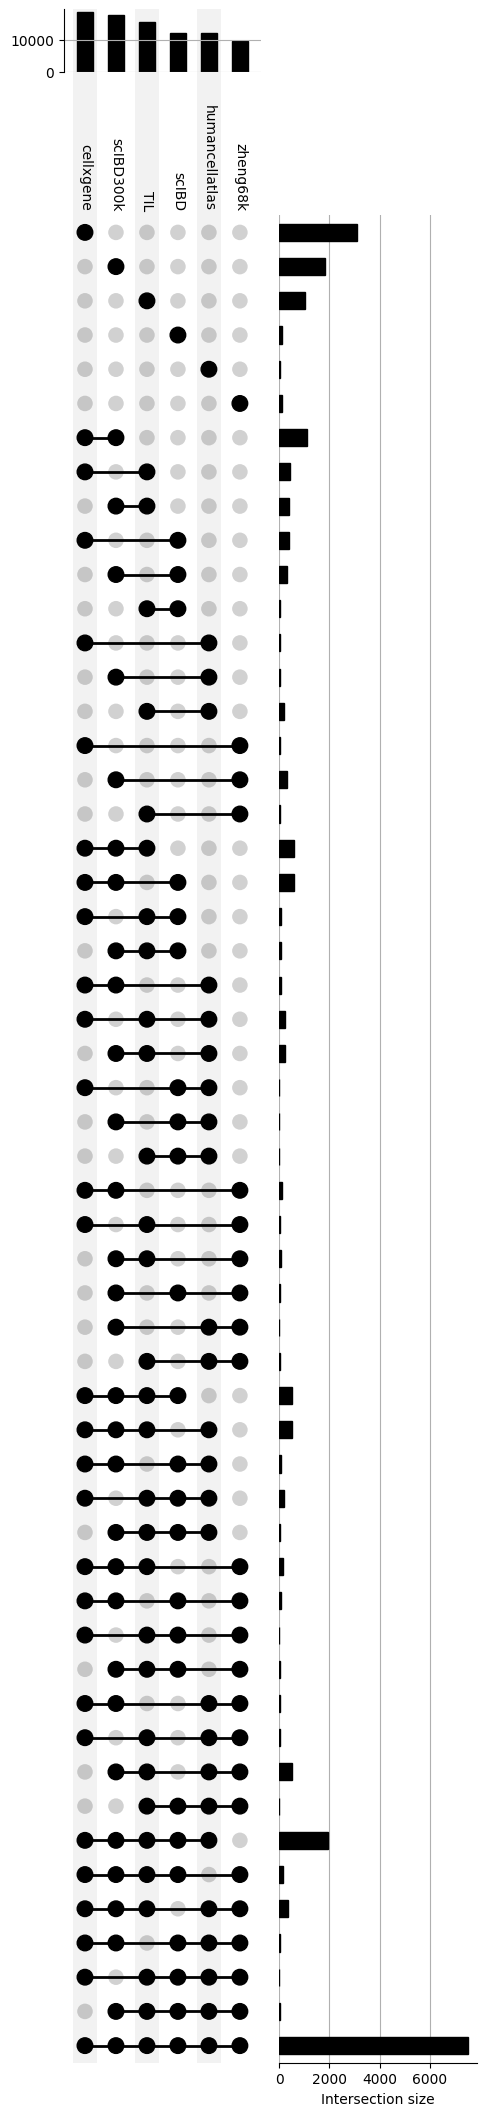

In [33]:
upsetplot.UpSet(up, orientation="vertical")

In [34]:
from venny4py.venny4py import venny4py


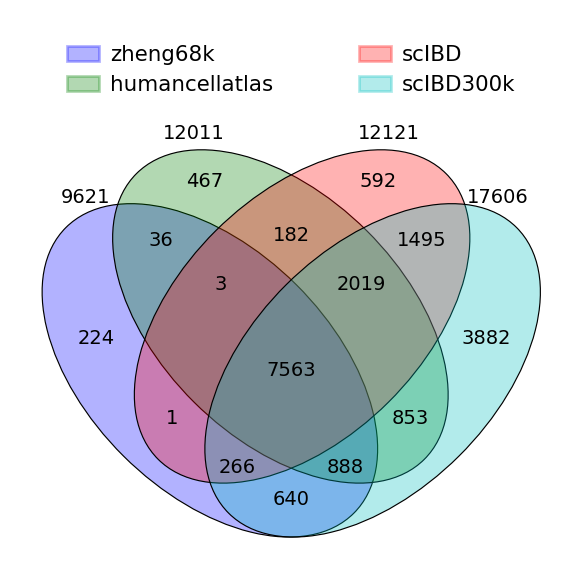

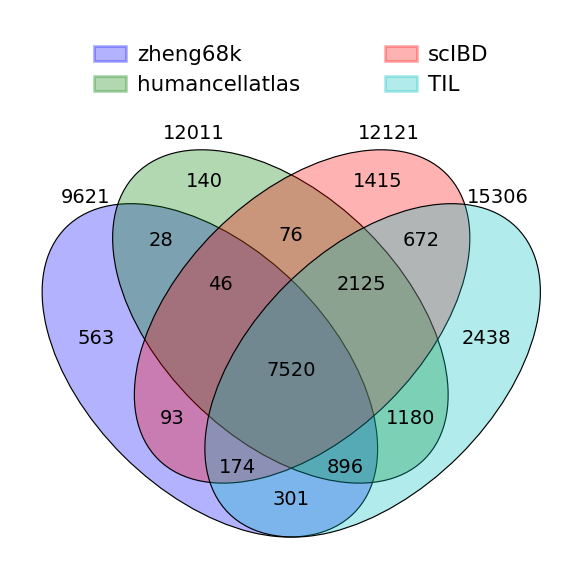

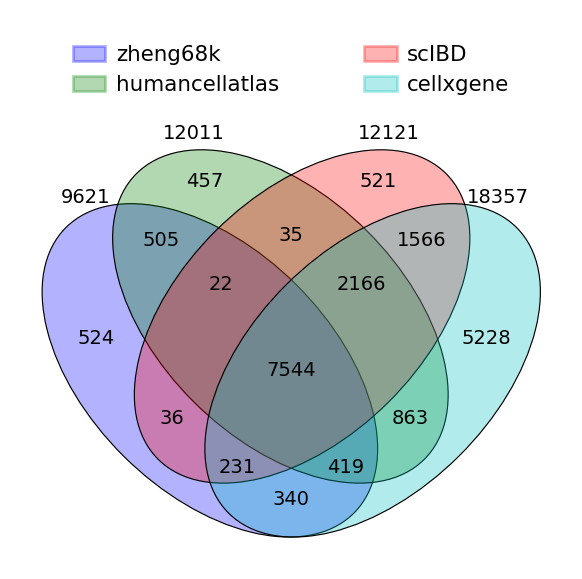

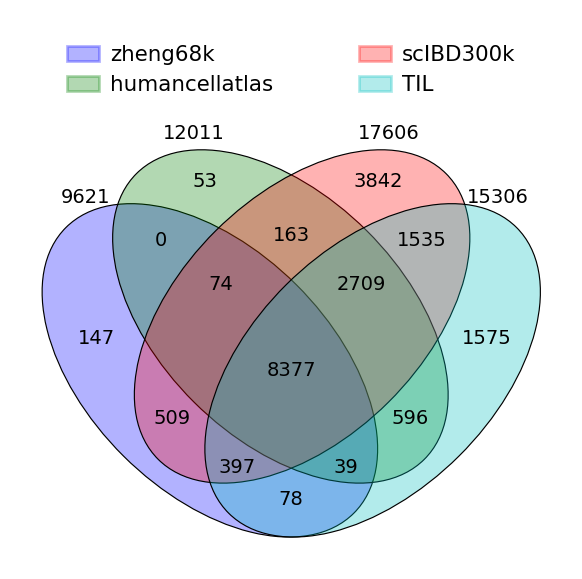

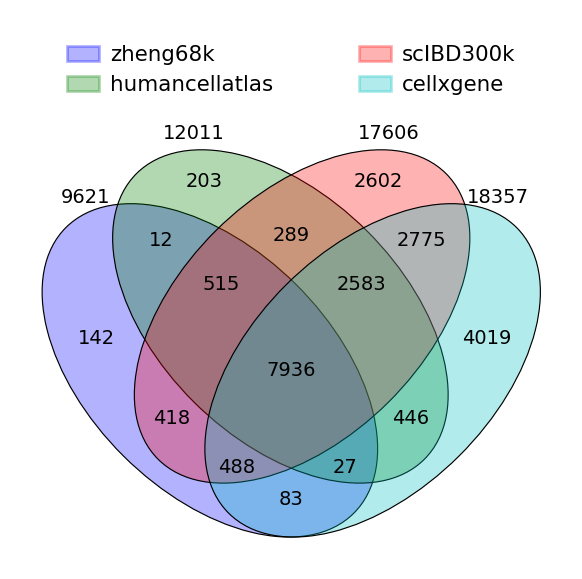

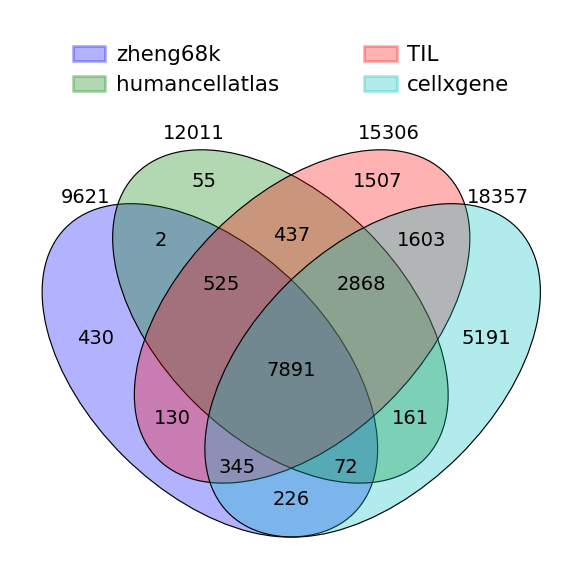

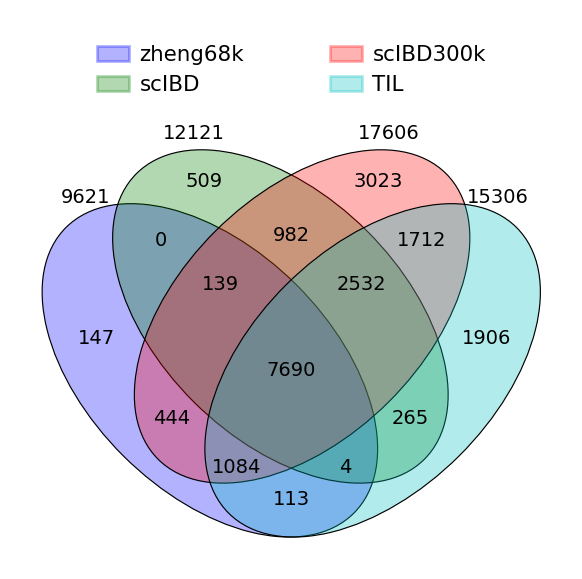

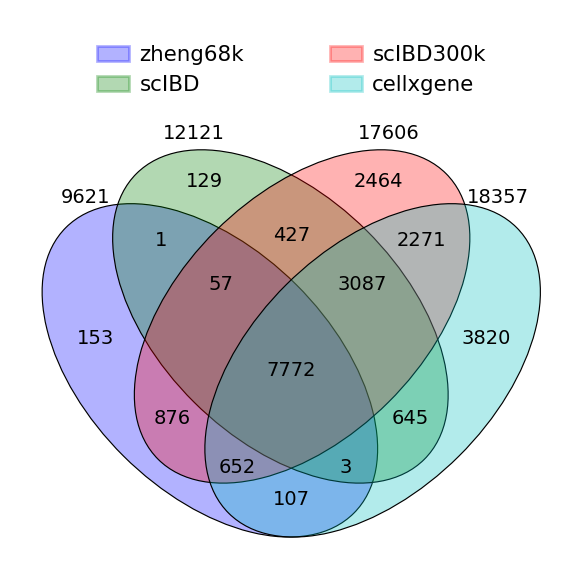

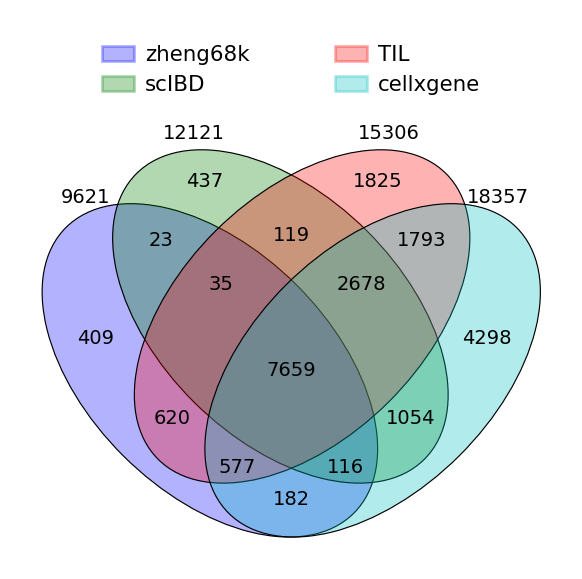

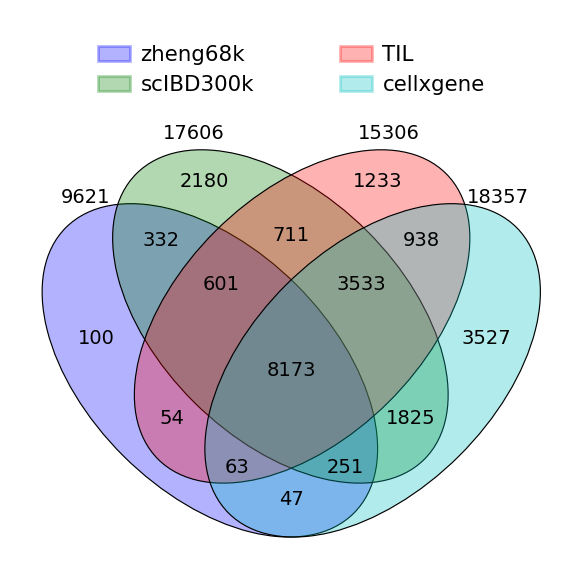

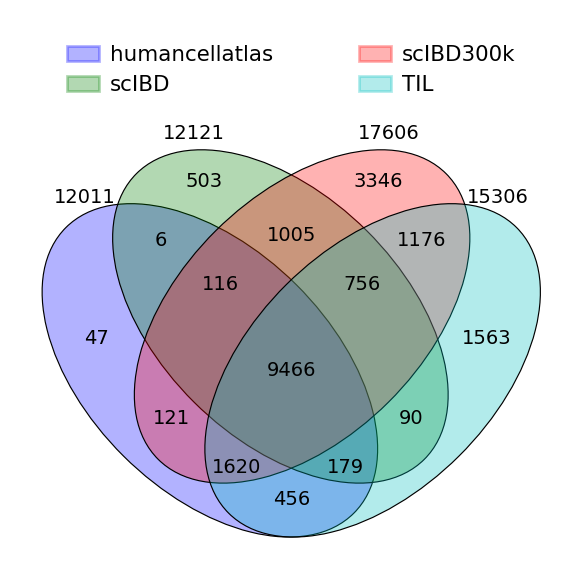

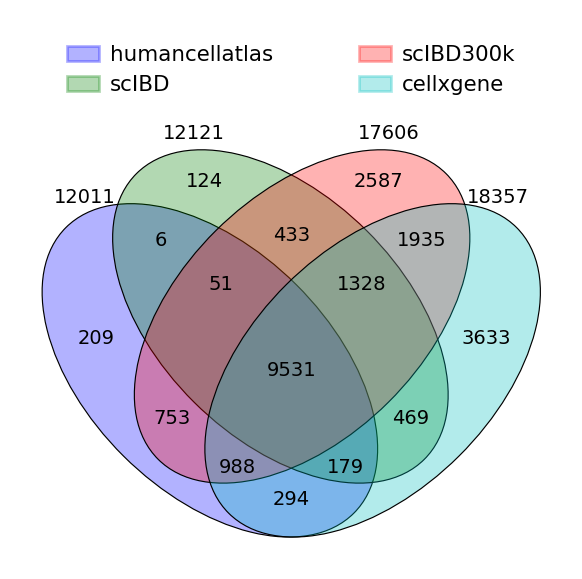

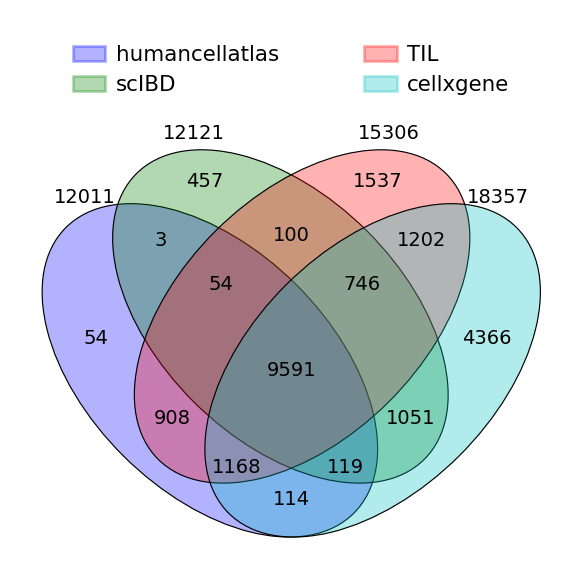

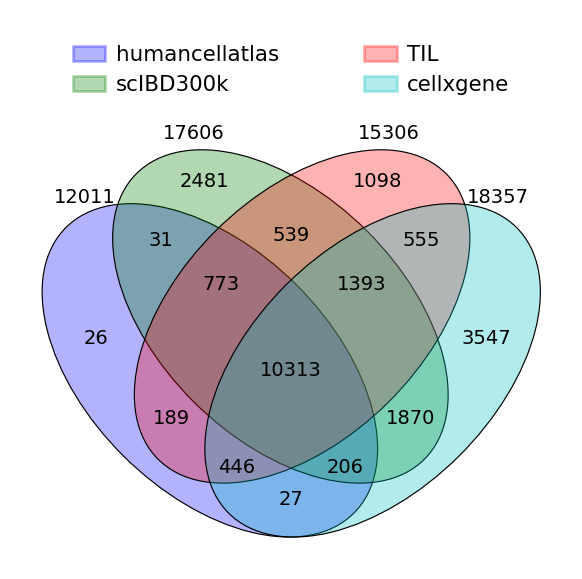

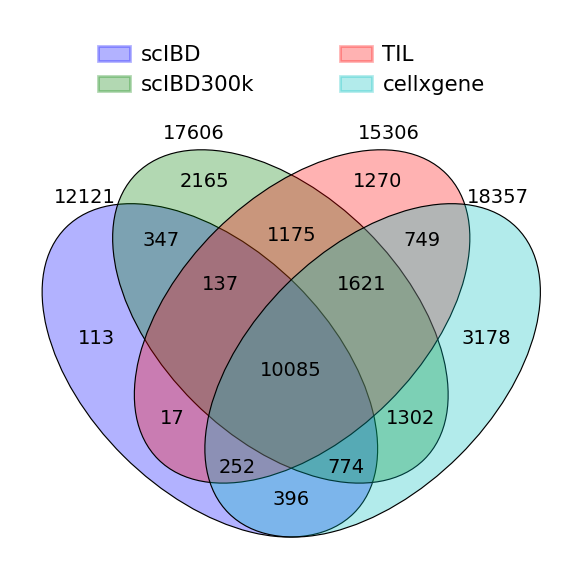

In [35]:
for c in combinations(vocabs, 4):
    venny4py(sets={k:v for k,v in vocabs.items() if k in c})
    

The bulkRNA is really problematic. Let's see if mapping helps. Let's focus on the bulk only ones.

In [36]:
model_path = "/dccstor/bmfm-targets/models/omics/transcriptome/scRNA/pretrain/bmfm.targets.slate.bert.110m.scRNA.pretrained.multifield.mask.multiloss.v1/"

In [37]:
panglao_vocab = {*load_tokenizer(model_path).vocab_get_field_specific_tokens("genes")[5:]}

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'MultiFieldTokenizer'.


In [38]:
def set_check(a,b):
    return (len(a), len(b)), (len(a|b), len(a&b)), (len(a-b), len(b-a))

In [39]:
set_check(panglao_vocab, {*gene2vec_vocab})

((46457, 24447), (51916, 18988), (27469, 5459))

In [40]:
set_check(panglao_vocab, {*gene_data.feature_name})

((46457, 60664), (76645, 30476), (15981, 30188))

In [41]:
big_vocabs =  {"panglao":panglao_vocab, 
     "cellxgene":{*gene_data.feature_name}, 
     "gene2vec": {*gene2vec_vocab}}
all_vocabs = {**vocabs, **big_vocabs, }

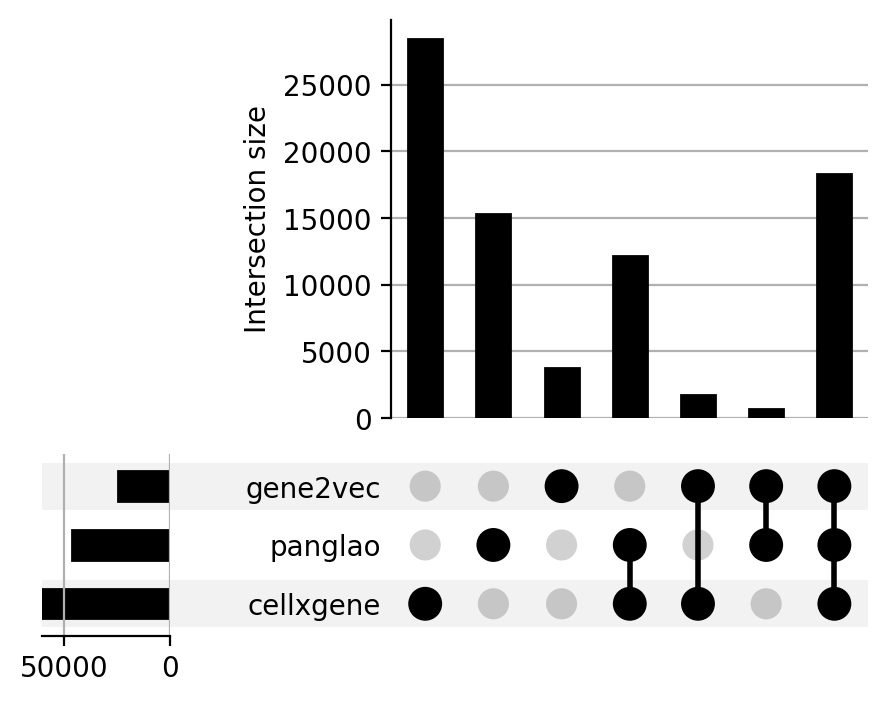

In [42]:
up = upsetplot.from_contents(big_vocabs)
upsetplot.UpSet(up, orientation="horizontal", min_subset_size=10)

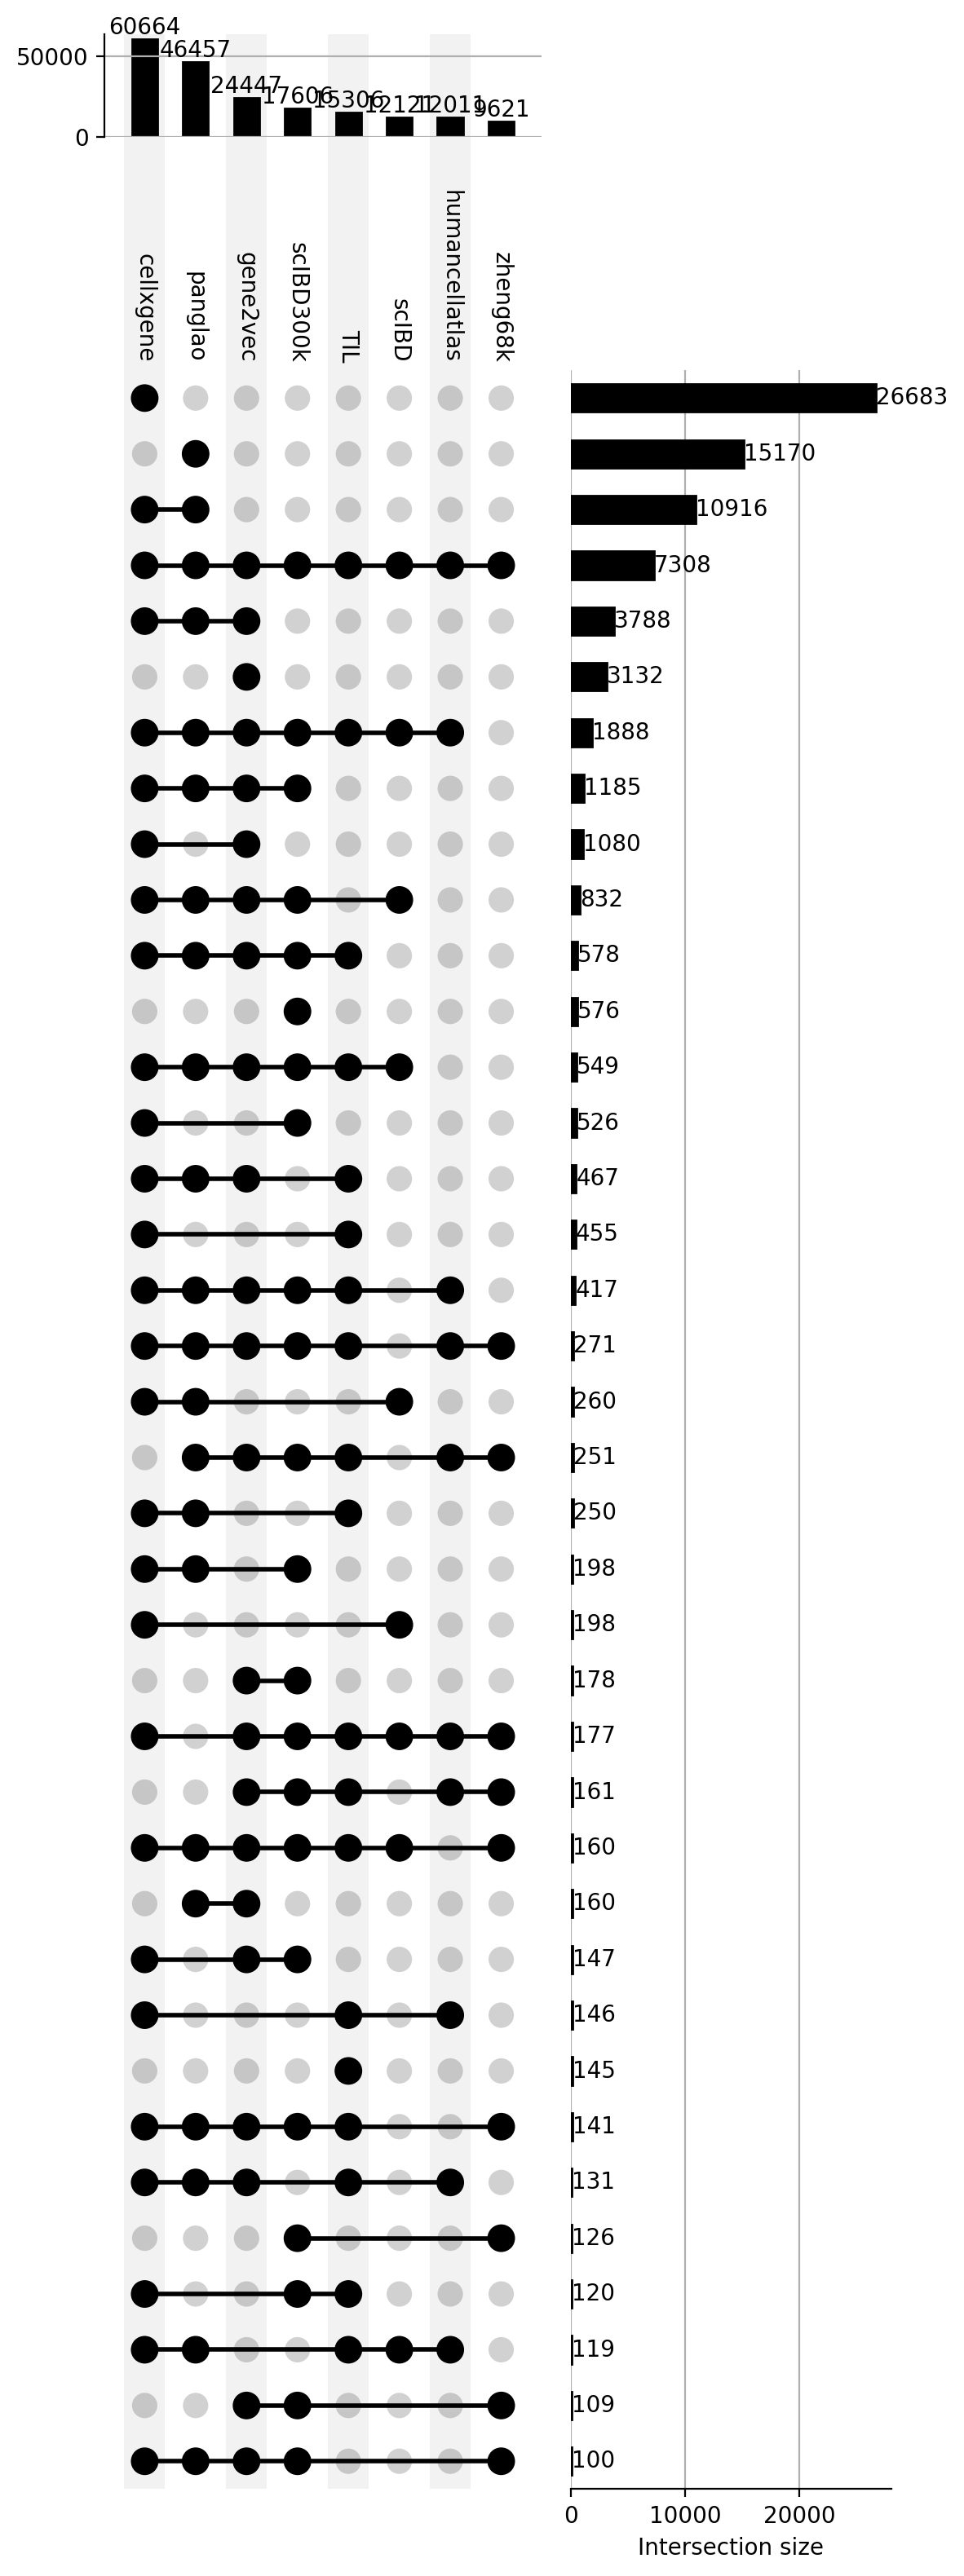

In [43]:
up = upsetplot.from_contents(all_vocabs)
upsetplot.UpSet(up, orientation="vertical", min_subset_size=100, show_counts=True, sort_by="cardinality")


In [44]:
union_all_vocabs = reduce( lambda x, y: x|y, all_vocabs.values())

In [45]:
len(union_all_vocabs)

81526

In [46]:
len(union_all_vocabs & {*prev_to_current_df.prev_symbol})

2273

In [47]:
len({*prev_to_current_df.symbol} - union_all_vocabs)

1350

In [48]:
bulk_rna_vocab = {*pd.read_csv("/dccstor/bmfm-targets/data/omics/transcriptome/bulkRNA/ALL/HTS/raw_genes_missing_in_vocab.csv")["0"].squeeze()}

In [49]:
set_check(union_all_vocabs, bulk_rna_vocab)

((81526, 12467), (90911, 3082), (78444, 9385))

In [50]:
len(bulk_rna_vocab & {*prev_to_current_df.prev_symbol})

105

In [51]:
from collections import Counter

sorted(Counter([i[:4] for i in bulk_rna_vocab - union_all_vocabs]).items(), key=lambda x: x[1], reverse=True)

[('LOC1', 7691),
 ('LINC', 139),
 ('SNOR', 97),
 ('MIR1', 44),
 ('TRL-', 32),
 ('LOC6', 31),
 ('TRG-', 30),
 ('TRC-', 29),
 ('SNAR', 28),
 ('TRV-', 28),
 ('TRR-', 26),
 ('TRS-', 26),
 ('TRK-', 25),
 ('LOC4', 25),
 ('TRI-', 22),
 ('TRN-', 22),
 ('TRT-', 20),
 ('TRP-', 20),
 ('TRQ-', 19),
 ('TRA-', 18),
 ('LOC7', 18),
 ('TRE-', 15),
 ('LOC3', 15),
 ('TRD-', 14),
 ('CFAP', 13),
 ('TRY-', 13),
 ('TRM-', 11),
 ('MIR9', 10),
 ('TRH-', 9),
 ('LOC2', 9),
 ('MIR3', 9),
 ('TRF-', 8),
 ('GARI', 8),
 ('TRX-', 8),
 ('SLC2', 7),
 ('TRW-', 7),
 ('TMEM', 7),
 ('GOLG', 7),
 ('FAM1', 6),
 ('FAM8', 6),
 ('SCAR', 6),
 ('PKD1', 5),
 ('FHIP', 5),
 ('UBE2', 5),
 ('FAM2', 5),
 ('RNA4', 5),
 ('RNA1', 5),
 ('ZNG1', 5),
 ('ZNF7', 5),
 ('ANKR', 5),
 ('RNA2', 5),
 ('SMIM', 4),
 ('DNAA', 4),
 ('CCDC', 4),
 ('PRDM', 4),
 ('TRNA', 4),
 ('GALN', 4),
 ('BLTP', 4),
 ('ARHG', 4),
 ('ZBTB', 4),
 ('PPP1', 4),
 ('XLOC', 3),
 ('SKIC', 3),
 ('BMAL', 3),
 ('NALF', 3),
 ('HSPA', 3),
 ('CDC2', 3),
 ('UQCC', 3),
 ('ATP1', 3),
 ('

In [52]:
all_with_bulk = bulk_rna_vocab | union_all_vocabs

In [53]:
len(all_with_bulk)

90911